<a href="https://colab.research.google.com/github/Molten-Ice/Deep-Learning/blob/dev/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!nvidia-smi

^C


Sun Mar 26 03:14:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.78       Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8     3W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import copy

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"on device: {device}")

on device: cpu


In [ ]:
# download images from github repository
# import wget
# !python -m wget https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/StarryNight.jpg
# !python -m wget https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/warwickCastle.jpg
!wget https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/StarryNight.jpg
!wget https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/warwickCastle.jpg


Saved under StarryNight.jpg

Saved under warwickCastle.jpg


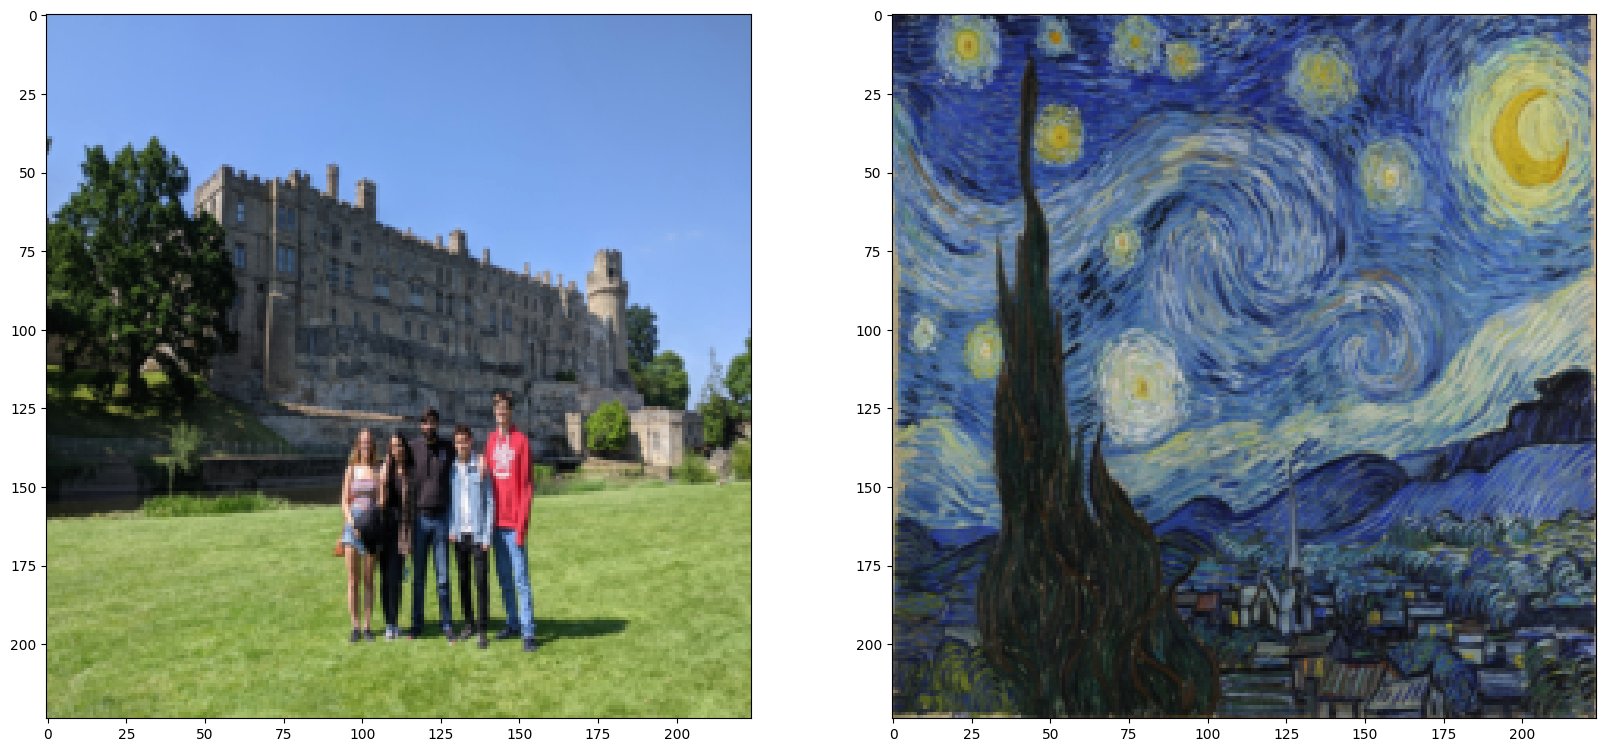

In [ ]:

def load_image(image_path):
  """ Load in and transform an image
  Parameters:
    image_path (str): path to the image
  Returns:
    A PyTorch Tensor to be used as input to the trained model
  """

  in_transform = transforms.Compose([
                        transforms.Resize((224, 224)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
  image = Image.open(image_path)
  image = in_transform(image).unsqueeze(dim=0)
  return image.to(device)

# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image, including unnormalizing it.
    Parameters:
      tensor (torch.Tensor): an input image tensor
    Returns:
    A NumPy array for the image, to be displayed using plt.imshow
    """
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

content = load_image("warwickCastle.jpg") # Delete 3!!
style = load_image("StarryNight.jpg")
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [ ]:
class NeuralStyleTransfer(nn.Module):
  def __init__(self):
    """Initialise the model"""
    super().__init__()
    self.model = torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.IMAGENET1K_V1).features[:29]

    for param in self.model.parameters():
      param.requires_grad_(False)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    """Forward pass of the model, storing the activations of intermediate layers
    Parameters:
      x (torch.Tensor) -- The input tensor
    Returns:
      activations (list of torch.Tensor's) -- The activations of the intermediate layers
      """
    activations = []
    output_idxs = [0, 5, 10, 19, 28]
    for idx, layer in enumerate(self.model):
      x = layer(x)
      if idx in output_idxs:
        activations.append(x)
    return activations

model = NeuralStyleTransfer().to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\James/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
34.3%


KeyboardInterrupt: 

In [ ]:
!nvidia-smi

Fri Mar 24 22:04:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla M60           On   | 00000001:00:00.0 Off |                  Off |
| N/A   42C    P0    38W / 150W |    429MiB /  8129MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def calculate_gram(x):
  """Calculate the gram matrix of a tensor"""
  _, c, w, h = x.shape
  x = x.view(c, -1)
  return x @ x.T 


content_activations = model(content)
# print([x.shape for x in content_activations])
style_activations = model(style)
style_grams = [calculate_gram(x) for x in style_activations]

[torch.Size([1, 64, 224, 224]), torch.Size([1, 128, 112, 112]), torch.Size([1, 256, 56, 56]), torch.Size([1, 512, 28, 28]), torch.Size([1, 512, 14, 14])]


In [ ]:
#create folder generated
!mkdir generated


Epoch: 0
loss: 83472.5859 | content(alpha) contribution: 0.0000 | style(beta) contribution: 83472.5830078


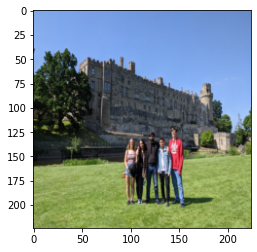


Epoch: 500
loss: 2073.7964 | content(alpha) contribution: 1.0600 | style(beta) contribution: 2072.7363586


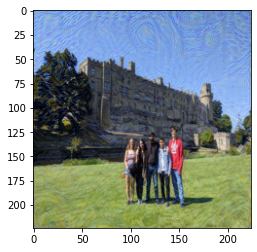


Epoch: 1000
loss: 1172.1185 | content(alpha) contribution: 1.3946 | style(beta) contribution: 1170.7239151


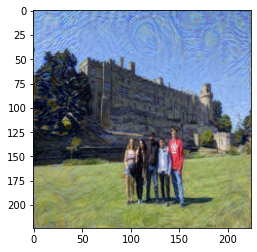


Epoch: 1500
loss: 832.2285 | content(alpha) contribution: 1.6014 | style(beta) contribution: 830.6270599


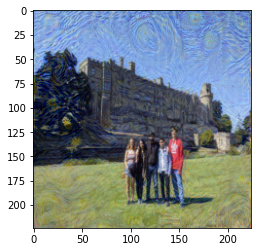


Epoch: 2000
loss: 652.8098 | content(alpha) contribution: 1.7489 | style(beta) contribution: 651.0607719


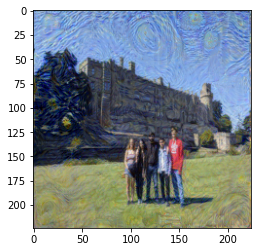


Epoch: 2500
loss: 543.7647 | content(alpha) contribution: 1.8636 | style(beta) contribution: 541.9011116


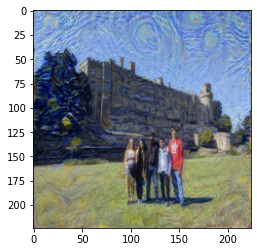


Epoch: 3000
loss: 470.0070 | content(alpha) contribution: 1.9545 | style(beta) contribution: 468.0524826


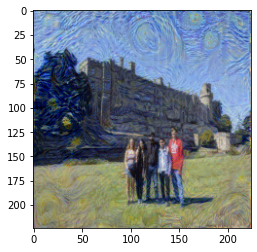


Epoch: 3500
loss: 414.9536 | content(alpha) contribution: 2.0334 | style(beta) contribution: 412.9201889


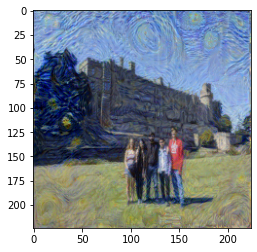


Epoch: 4000
loss: 377.1655 | content(alpha) contribution: 2.1018 | style(beta) contribution: 375.0637054


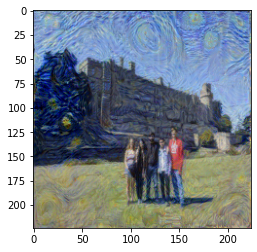


Epoch: 4500
loss: 346.0256 | content(alpha) contribution: 2.1603 | style(beta) contribution: 343.8652992


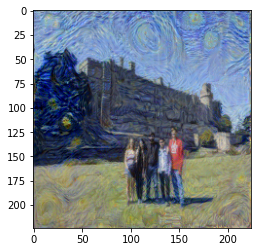

In [ ]:
## Hyperparameters

beta = 200
learning_rate = 3e-3
epochs = 5000
content_idx = 1
style_weights = [1, 1, 1, 1, 1]

generated = content.clone().requires_grad_(True).to(device)

optimizer = torch.optim.AdamW([generated], lr=learning_rate, betas=[0.5, 0.999])
model.train()
for epoch in range(epochs):   
  generated_activations = model(generated)
  content_loss = torch.mean((generated_activations[content_idx] - content_activations[content_idx])**2) # changed mean

  style_loss = 0
  generated_grams = [calculate_gram(x) for x in generated_activations]
  for i, (g, s) in enumerate(zip(generated_grams, style_grams)):
    _, c, w, h = generated_activations[i].shape
    style_loss+=style_weights[i]*torch.mean((g-s)**2) / ((c*w*h))

  loss = content_loss + beta*style_loss

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # display intermediate images and print the loss
  if epoch % 500 == 0:
      print(f"\nEpoch: {epoch}")
      print(f"loss: {loss.item():.4f} | content(alpha) contribution: {alpha*content_loss.item():.4f} | style(beta) contribution: {beta*style_loss.item():.7f}")
      plt.imshow(im_convert(generated))
      plt.savefig(f'generated/{epoch}.png')
      plt.show()

In [ ]:
## crea

In [ ]:
! python -m pip install --upgrade pip
! pip install pandas

     |████████████████████████████████| 2.1 MB 5.8 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.1.1
    Uninstalling pip-20.1.1:
      Successfully uninstalled pip-20.1.1


In [ ]:
# create a gif of the images without using imageio
import os
import glob
import contextlib
from PIL import Image

# filepaths
fp_in = "generated/*.png"
fp_out = "generated/generated.gif"

# use exit stack to automatically close opened images
with contextlib.ExitStack() as stack:

        # lazily load images
        imgs = (stack.enter_context(Image.open(f))
                for f in sorted(glob.glob(fp_in)))

        # extract  first image from iterator
        img = next(imgs)

        # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
        img.save(fp=fp_out, format='GIF', append_images=imgs,
                save_all=True, duration=200, loop=0)

        print(f"Saved at {fp_out}")


Saved at generated/generated.gif


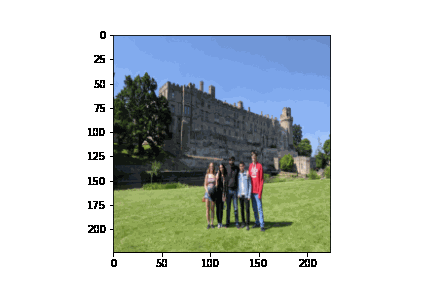

In [ ]:
#display the gif
from IPython.display import Image
Image(filename='generated/generated.gif')